In [2]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist

%load_ext autoreload
%autoreload 2

## Helper Classes

In [3]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass')

## Trained Classification Models

In [22]:
MODEL_DETAILS_DICT = {
    # BNN
    "bnn_1200": ModelDetails("../saved_models/BBB_classification/2022-03-15-09.18.07", ClassificationBNN),
    "bnn_800": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.25.46", ClassificationBNN),
    "bnn_400": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.26.34", ClassificationBNN),
    # DNN - no dropout
    "dnn_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-14.28.25", ClassificationDNN),
    "dnn_800": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.06.09", ClassificationDNN),
    "dnn_400": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.10.34", ClassificationDNN),
    # DNN - dropout
    "dnn_do_400": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.21.46", ClassificationDNN),
    "dnn_do_800": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.58.04", ClassificationDNN),
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.26.18", ClassificationDNN),
}

## Set Model

In [41]:
MODEL = "dnn_do_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
MODEL_DETAILS

ModelDetails(dir='../saved_models/DNN_classification/2022-03-15-16.26.18', mclass=<class 'bbb.models.dnn.ClassificationDNN'>)

## Load Parameters

In [42]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if params_dict['prior_params']:
    params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

params = Parameters(**params_dict)
params

Parameters(name='DNN_classification', input_dim=784, output_dim=10, batch_size=128, epochs=300, hidden_units=400, hidden_layers=3, lr=0.0001, step_size=75, opt_choice='Adam', gamma=0.1, weight_mu_range=None, weight_rho_range=None, prior_params=None, elbo_samples=None, inference_samples=None, regression_likelihood_noise=None, kl_reweighting_type=None, vp_variance_type=None, prior_type=None, local_reparam_trick=False, dropout=True, dropout_p=0.5, early_stopping=False, early_stopping_thresh=0, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

## Load Data

In [ ]:
img = inputs[1].squeeze()
label = labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [26]:
X_val = load_mnist(train=False, batch_size=params.batch_size, shuffle=True)

/Users/maxbronckers/Downloads/BBB/env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Load Model

In [43]:
# net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

<All keys matched successfully>

## Evaluate

In [51]:
correct = 0
total = 0

classes = list(range(0, 10))
dict = {}
preds_dict = {}
probs_dict = {}
for c in classes:
    dict[c] = {}
    dict[c]['preds'] = []
    dict[c]['probs'] = []
    dict[c]['correct'] = 0
    dict[c]['total'] = 0
    
with torch.no_grad():
    for inputs, labels in X_val:
        # inputs = inputs.to(DEVICE)
        # labels = labels.to(DEVICE)
        
        preds, probs = net.predict(inputs)

        total += net.batch_size
        correct += (labels == preds).sum()

        # filter by class label        
        for c in classes:
            val_filter = np.where(labels == c)
            
            c_preds = preds[val_filter]
            c_probs = probs[val_filter]

            c_preds = c_preds.cpu().detach().numpy()
            c_probs = c_probs.cpu().detach().numpy()
            dict[c]['probs'].extend(c_probs)
            dict[c]['preds'].extend(c_preds)

            dict[c]['probs'].append(c_probs)
            dict[c]['preds'].append(c_preds)

            dict[c]['correct'] += (c_preds == c).sum()
            dict[c]['total'] += len(c_preds)
            
eval_score = correct / total
print(eval_score)

tensor(0.9785)


In [ ]:
# net.evaluate(X_val)

tensor(0.9836)

In [48]:
net.weight_samples()


[tensor([-0.0300, -0.0192,  0.0322,  ...,  0.0339, -0.0038,  0.0344],
        grad_fn=<ViewBackward>),
 tensor([ 0.0261, -0.0170, -0.0016,  ..., -0.0820,  0.1101,  0.0149],
        grad_fn=<ViewBackward>),
 tensor([ 0.1667, -0.2479, -0.0873,  ..., -0.4562,  0.2381, -0.4374],
        grad_fn=<ViewBackward>)]

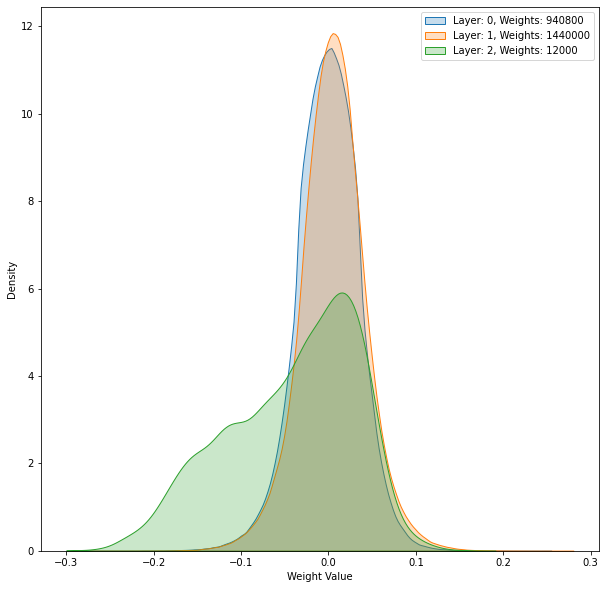

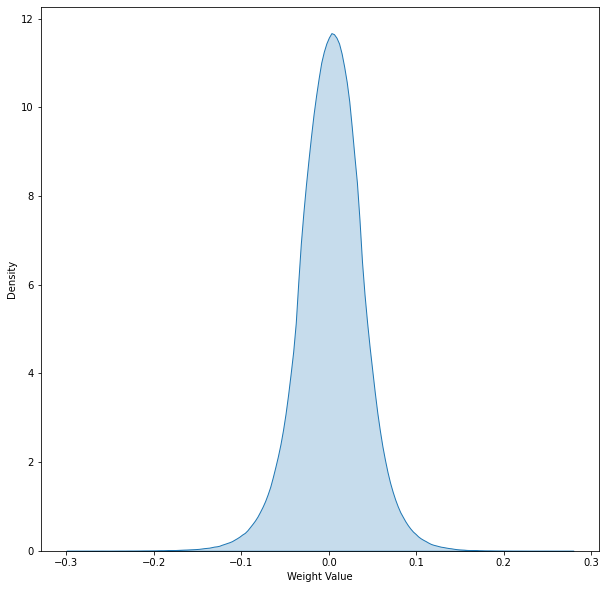

In [37]:
plot_weight_samples(net.weight_samples())

## Recorded Metrics

In [ ]:
from IPython.display import Image
comb_weights_plot_path = os.path.join(MODEL_DETAILS.dir, 'comb_weights_plot.png')
Image(filename=comb_weights_plot_path) 

In [19]:
eval_metric = np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))

In [21]:
eval_metric[-1]

0.9863781929016113

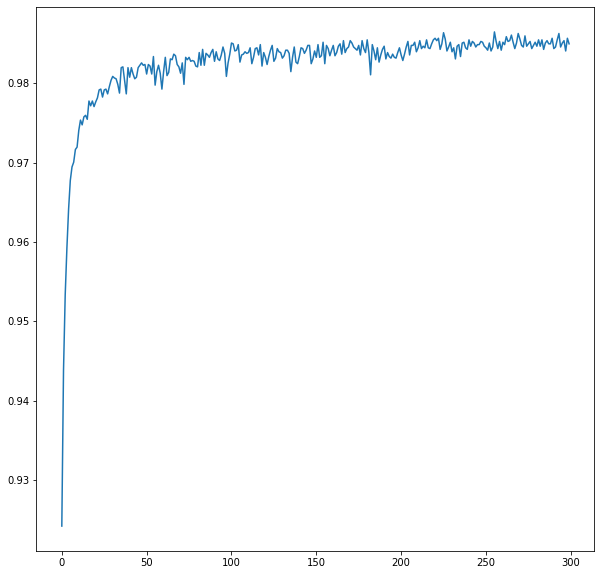

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(eval_metric)

In [ ]:
loss = np.load(os.path.join(MODEL_DETAILS.dir, 'loss.npy'))

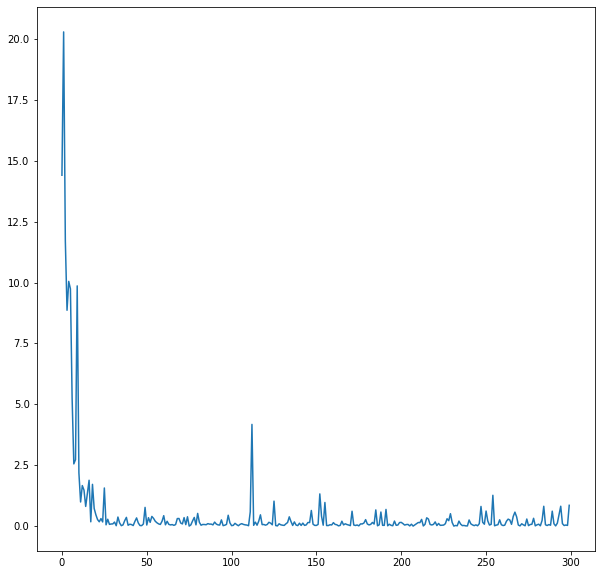

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(loss)